# Figure Notebook

In [1]:
"""
Import needed libraries
"""

import numpy as np
import pandas as pd
from copy import copy
import sys
import itertools
from netCDF4 import Dataset

"""
Import all from projects python scripts
"""

from geomip_data_smb import *
from analysis import *
from plotting import *

Could not load xarray


In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300 # set inline images to hi-res
%matplotlib inline

In [26]:
"""
Set standard plot options
"""

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'figure.figsize': cm2inch(8.5,8.5)})

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
"""
Set up variable and other lists
"""

model_list = ['GISS-E2-R','HadCM3', 'BNU-ESM', 'CCSM4', 'CESM-CAM5.1-FV', 'CanESM2', 'CSIRO-Mk3L-1-2','HadGEM2-ES' ,'IPSL-CM5A-LR','MIROC-ESM','MPI-ESM-LR','NorESM1-M']
seas_list = ['ann','jja','djf']
exp_list = ['piControl','abrupt4xCO2','G1']

var_list, var_offsets, var_mults, var_name_mod = [], {}, {}, {}

s2d = 60.0*60.0*24.0
k2c = -273.15

def add_var(var_name, offset, mult, name_mod):
    var_list.append(var_name)
    var_offsets[var_name] = offset
    var_mults[var_name] = mult
    var_name_mod[var_name] = name_mod

# Climate stuff
add_var('tas_Amon',k2c,1.0, "")         # 2m temp
add_var('pr_Amon', 0.0, s2d, "")            # Precip - evap
add_var('p-e_Amon', 0.0, s2d, "")            # Precip - evap
add_var('prsn_Amon', 0.0, s2d, "")          # snowfall
add_var('evspsbl_Amon', 0.0, s2d, "")       # total evap
add_var('sbl_Amon', 0.0, s2d, "")           # sublimation
add_var('ts_Amon', k2c, 1.0, "")        # surface temp
add_var('hurs_Amon', 0.0, 1.0, "")          # relative humidity
# Energy flux at surface
add_var('rlus_Amon',0.0,1.0,"")             # LW up 
add_var('rlds_Amon',0.0,1.0,"")             # LW down
add_var('rsus_Amon',0.0,1.0,"")             # SW up
add_var('rsds_Amon',0.0,1.0,"")             # SW down
add_var('hfss_Amon',0.0,1.0,"")             # sensible heat up
add_var('hfls_Amon',0.0,1.0,"")             # latent heat up
# Snow Stuff
add_var('lwsnl_LImon',0.0,1.0,"")           # liquid water snow
add_var('snd_LImon',0.0,1.0,"")             # fresh snow thickness
add_var('snm_LImon',0.0,s2d,"")             # snow melt
add_var('hfdsn_LImon',0.0,1.0,"")           # heat flux into snow
add_var('tsn_LImon',k2c,1.0,"")         # snow temperature
add_var('snw_LImon',0.0,1.0,"")             # snow mass


In [5]:
"""
Load up masks
"""

masks_dict = {}
weights_dict = {}

mask_list = ['global','land_noice','greenland','antarctica']

for model in model_list:
    
    model_masks = get_masks_weights(model)
    
    for mask in mask_list:
        
        masks_dict[model, mask] = model_masks[1][mask]
        weights_dict[model, mask] = model_masks[2][mask+'_area']

In [6]:
"""
Load up variables
"""

means_dict = {}
stds_dict = {}

# 4 nested for-loops squashed into one!
for var, model, exp, seas in itertools.product(var_list, model_list, exp_list, seas_list):
               
    # look up run for model-exp combo
    run = model_exp_runs[model+'_'+exp][0]

    try:
        means_dict[var, model, exp, seas] = var_mults[var] * get_2d_geomip(var, model, exp, run, seas, 'mean') + var_offsets[var]
    except:
        means_dict[var, model, exp, seas] = None
    try:
        stds_dict[var, model, exp, seas] = var_mults[var] * get_2d_geomip(var, model, exp, run, seas, 'std')
    except:
        stds_dict[var, model, exp, seas] = None

In [7]:
"""
create surface heat variables
"""

# add surface heat to means_dict
for model, exp, seas in itertools.product(model_list, exp_list, seas_list):
    
    # load all vars
    rsds = means_dict['rsds_Amon', model, exp, seas]
    rsus = means_dict['rsus_Amon', model, exp, seas]
    rlds = means_dict['rlds_Amon', model, exp, seas]
    rlus = means_dict['rlus_Amon', model, exp, seas]
    hfss = means_dict['hfss_Amon', model, exp, seas]
    hfls = means_dict['hfls_Amon', model, exp, seas]
    
    sfc_vars = [rsds,rsus,rlds,rlus,hfss,hfls]
    
    # calculate
    if any(type(t) == type(None) for t in sfc_vars):
        sfc_heat, sfc_rad, sfc_nonrad, sfc_sw, sfc_lw = None, None, None, None, None
    else:
        sfc_heat = rsds + rlds - rsus - rlus - hfss - hfls
        sfc_rad = rsds + rlds - rsus - rlus
        sfc_nonrad = - hfss - hfls
        sfc_sw = rsds - rsus
        sfc_lw = rlds - rlus
    
    # add vars
    means_dict['sfc_heat_Amon', model, exp, seas] = sfc_heat
    means_dict['sfc_rad_Amon', model, exp, seas] = sfc_rad
    means_dict['sfc_nonrad_Amon', model, exp, seas] = sfc_nonrad
    means_dict['sfc_sw_Amon', model, exp, seas] = sfc_sw
    means_dict['sfc_lw_Amon', model, exp, seas] = sfc_lw
    
var_list.extend(['sfc_heat_Amon','sfc_rad_Amon','sfc_nonrad_Amon','sfc_sw_Amon','sfc_lw_Amon'])

# Analysis Begins

In [8]:
# apply mask to data and take sum
def masked_sum(var,model,exp,seas,mask):
    
    # if exception is thrown return NAN
    try:
        data = np.sum(means_dict[var, model,exp,seas] * weights_dict[model,mask])
    except:
        data = np.nan
        
    return data

In [82]:
# return GMT scaling factor to adjust model results to produce G1* that restores pic GMT
def t_factor(model, mask='global'):
    # calculate ann-mean, global-mean SAT for each experiment
    var, seas = 'tas_Amon','ann'
    pic = masked_sum(var,model,'piControl',seas,mask)
    CO2 = masked_sum(var,model,'abrupt4xCO2',seas,mask)
    G1 = masked_sum(var,model,'G1',seas,mask)
    
    # offset ratio is greater than 1 if G1 offsets more than it should, and vice versa
    offset_ratio = (CO2 - G1) / (CO2 - pic)
    
    # Scaling factor for all results is one over offset_ratio which will produce results with pic GMT
    return 1. / offset_ratio

## Rescaled results to restore global, greenland and antarctic temperatures to control

# Big Table
The goal is to produce a big table of results that show picontrol and both anomalies.
Each table will have rows of model results and columns of var_anom pairs. Tables will be produced for each mask-season combo.

In [10]:
def add_mean_median(dict_in):
    dict_in['_mean'] = np.nanmean(dict_in.values())
    dict_in['_median'] = np.nanmedian(dict_in.values())

In [99]:
table_dir = "/n/home03/pjirvine/projects/GeoMIP_SMB/tables/"

# dictionary to store dataframes / tables
df_dict = {}

# One table for each mask-seas combo
for mask, seas in itertools.product(mask_list, seas_list):

    var_anom_dict = {}

    for var in var_list:

        pic_dict, CO2_anom_dict, G1_anom_dict, G1x_anom_dict, G1xg_anom_dict, G1xa_anom_dict = {}, {}, {}, {}, {}, {}

        #Calculate and store control and anom values per model
        for model in model_list:

            pic = masked_sum(var,model,'piControl',seas,mask)
            CO2 = masked_sum(var,model,'abrupt4xCO2',seas,mask)
            G1 = masked_sum(var,model,'G1',seas,mask)
            # produce G1x results with G1 rescaled to reproduce pic GMT
            G1x = CO2 + t_factor(model) * (G1 - CO2)
            # produce G1xgresults with G1 rescaled to reproduce pic Greenland SAT
            G1xg = CO2 + t_factor(model,mask='greenland') * (G1 - CO2)
            # produce G1x results with G1 rescaled to reproduce pic Antarctic SAT
            G1xa = CO2 + t_factor(model,mask='antarctica') * (G1 - CO2)
            
            pic_dict[model] = pic
            CO2_anom_dict[model] = CO2 - pic
            G1_anom_dict[model] = G1 - pic
            G1x_anom_dict[model] = G1x - pic
            G1xg_anom_dict[model] = G1xg - pic
            G1xa_anom_dict[model] = G1xa - pic

        add_mean_median(pic_dict)
        add_mean_median(CO2_anom_dict)
        add_mean_median(G1_anom_dict)
        add_mean_median(G1x_anom_dict)
        add_mean_median(G1xg_anom_dict)
        add_mean_median(G1xa_anom_dict)
        
        var_short = var.replace('_Amon', '').replace('_LImon', '')
        var_anom_dict[var_short+'_pic'] = pic_dict
        var_anom_dict[var_short+'_CO2_anom'] = CO2_anom_dict
        var_anom_dict[var_short+'_G1_anom'] = G1_anom_dict
        var_anom_dict[var_short+'_G1x_anom'] = G1x_anom_dict
        var_anom_dict[var_short+'_G1xg_anom'] = G1xg_anom_dict
        var_anom_dict[var_short+'_G1xa_anom'] = G1xa_anom_dict

    # Convert dictionary to dataframe, store and also output as csv table.
    df = pd.DataFrame.from_dict(var_anom_dict)
    df_dict[mask,seas] = df
    df.to_csv(table_dir+'{mask}_{seas}.csv'.format(mask=mask,seas=seas))

/n/home03/pjirvine/.conda/envs/analysis_01_06_18/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [100]:
# # Extract dataframe like this:
# print df_dict['global','ann']
# # Extract columns from dataframe like this:
# print df_dict['global','ann']['evspsbl_CO2_anom']
# # Extract list of values like this:
# print df_dict['global','ann']['evspsbl_CO2_anom'].values

# Model dot plots

In [109]:
"""
General plot settings and functions
"""

out_dir = '/n/home03/pjirvine/projects/GeoMIP_SMB/figures/'

n_models = 12
indices = df_dict['global','ann']['tas_CO2_anom'].index.values
models = indices[0:n_models]
model_cols = ['maroon','saddlebrown','red','darkorange','gold','olive','darkgreen','teal','dodgerblue','mediumblue','darkviolet','deeppink']

def get_model_data(mask, seas, var_short, exp_anom):
    df = df_dict[mask,seas][var_short+'_'+exp_anom]
    return df.values[0:12]

def plot_models(y_val, series):
#     y_vals = 12 * [y_val]
    for idx in xrange(12):
        plt.plot(series[idx], y_val, 'o', color=model_cols[idx])

102.52935609183842 77.39801498990292
114.86335863703043 71.49834084995277
121.65599694376826 82.98304022322691
143.24312503350933 86.68899725197906
129.3569267582764 89.8880955041049


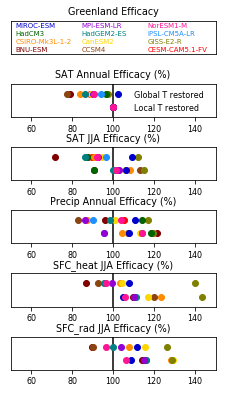

In [110]:
"""
G1x and G1xx efficacy plots
"""

def plot_eff_set(mask, seas, var, extra_anom, test=True): # extra anom = G1xg_anom OR G1xa_anom
    
    y_G1x_eff = 0.7
    y_G1xx_eff = 0.3
    
    G1x_eff = 100.0 * (get_model_data(mask, seas, var, 'CO2_anom') - get_model_data(mask, seas, var, 'G1_anom')) / get_model_data(mask, seas, var, 'CO2_anom')
    G1xx_eff = 100.0 * (get_model_data(mask, seas, var, 'CO2_anom') - get_model_data(mask, seas, var, extra_anom)) / get_model_data(mask, seas, var, 'CO2_anom')

    plot_models(y_G1x_eff, G1x_eff)
    plot_models(y_G1xx_eff, G1xx_eff)
                  
    if test:
        print np.nanmax(np.concatenate((G1x_eff, G1xx_eff))), np.nanmin(np.concatenate((G1x_eff, G1xx_eff)))

"""
Greenland
"""

fig = plt.figure(figsize=cm2inch(8.5,14))

"""
Legend
"""
ax = fig.add_subplot(611)

# array of model names
nx, ny = (3,4)
x = np.linspace(0.03,0.8,nx)
y = np.linspace(0.07,0.8,ny)
xv,yv = np.meshgrid(x,y)
xv, yv = (xv.flatten(), yv.flatten())

# plot model_names
for i in xrange(n_models):
    plt.text(xv[i], yv[i], models[i],color=model_cols[i], fontsize=7)

ax.set_ylim(0,1)
ax.set_xlim(0,1.2)
ax.set_title('Greenland Efficacy')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
# ax.get_xaxis().set_ticklabels([])
# ax.get_yaxis().set_ticklabels([])

"""
SAT ann plot
"""
ax = fig.add_subplot(612)

ax.axvline(100.0, color='k')

plot_eff_set('greenland', 'ann', 'tas', 'G1xg_anom')

ax.set_ylim(0,1)
ax.set_xlim(50,150)
ax.set_title('SAT Annual Efficacy (%)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False) # suppress X labels

plt.text(110,0.6,'Global T restored')
plt.text(110,0.2,'Local T restored')

"""
SAT JJA plot
"""
ax = fig.add_subplot(613)

ax.axvline(100.0, color='k')

plot_eff_set('greenland', 'jja', 'tas', 'G1xg_anom')

ax.set_ylim(0,1)
ax.set_xlim(50,150)
ax.set_title('SAT JJA Efficacy (%)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False) # suppress X labels

"""
Precip Ann plot
"""
ax = fig.add_subplot(614)

ax.axvline(100.0, color='k')

plot_eff_set('greenland', 'ann', 'pr', 'G1xg_anom')

ax.set_ylim(0,1)
ax.set_xlim(50,150)
ax.set_title('Precip Annual Efficacy (%)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False) # suppress X labels

"""
sfc_heat JJA plot
"""
ax = fig.add_subplot(615)

ax.axvline(100.0, color='k')

plot_eff_set('greenland', 'jja', 'sfc_heat', 'G1xg_anom')

ax.set_ylim(0,1)
ax.set_xlim(50,150)
ax.set_title('SFC_heat JJA Efficacy (%)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False) # suppress X labels

"""
sfc_rad JJA plot
"""
ax = fig.add_subplot(616)

ax.axvline(100.0, color='k')

plot_eff_set('greenland', 'jja', 'sfc_rad', 'G1xg_anom')

ax.set_ylim(0,1)
ax.set_xlim(50,150)
ax.set_title('SFC_rad JJA Efficacy (%)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False) # suppress X labels

plt.subplots_adjust(top=0.98, bottom=0.1, left=0.10, right=0.95, hspace=0.9,
                    wspace=0.35)

plt.savefig(out_dir+'greenland_eff.png', format='png', dpi=480)
plt.savefig(out_dir+'greenland_eff.eps', format='eps', dpi=480)

plt.show()

107.75739259242636 79.4530518466288
117.96946550451202 87.9445211296965
151.47614282178722 84.22760804410817
288.9661834523705 21.900556710793587
203.18725119256 92.93406472711807


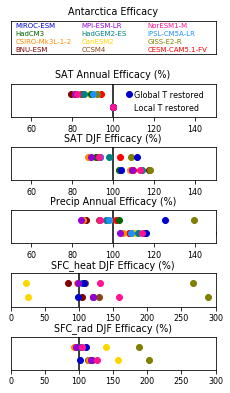

In [111]:
"""
Antarctica
"""

fig = plt.figure(figsize=cm2inch(8.5,14))

"""
Legend
"""
ax = fig.add_subplot(611)

# array of model names
nx, ny = (3,4)
x = np.linspace(0.03,0.8,nx)
y = np.linspace(0.07,0.8,ny)
xv,yv = np.meshgrid(x,y)
xv, yv = (xv.flatten(), yv.flatten())

# plot model_names
for i in xrange(n_models):
    plt.text(xv[i], yv[i], models[i],color=model_cols[i], fontsize=7)

ax.set_ylim(0,1)
ax.set_xlim(0,1.2)
ax.set_title('Antarctica Efficacy')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
# ax.get_xaxis().set_ticklabels([])
# ax.get_yaxis().set_ticklabels([])

"""
SAT ann plot
"""
ax = fig.add_subplot(612)

ax.axvline(100.0, color='k')

plot_eff_set('antarctica', 'ann', 'tas', 'G1xa_anom')

ax.set_ylim(0,1)
ax.set_xlim(50,150)
ax.set_title('SAT Annual Efficacy (%)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False) # suppress X labels

plt.text(110,0.6,'Global T restored')
plt.text(110,0.2,'Local T restored')

"""
SAT JJA plot
"""
ax = fig.add_subplot(613)

ax.axvline(100.0, color='k')

plot_eff_set('antarctica', 'djf', 'tas', 'G1xa_anom')

ax.set_ylim(0,1)
ax.set_xlim(50,150)
ax.set_title('SAT DJF Efficacy (%)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False) # suppress X labels

"""
Precip Ann plot
"""
ax = fig.add_subplot(614)

ax.axvline(100.0, color='k')

plot_eff_set('antarctica', 'ann', 'pr', 'G1xa_anom')

ax.set_ylim(0,1)
ax.set_xlim(50,150)
ax.set_title('Precip Annual Efficacy (%)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False) # suppress X labels

"""
sfc_heat JJA plot
"""
ax = fig.add_subplot(615)

ax.axvline(100.0, color='k')

plot_eff_set('antarctica', 'djf', 'sfc_heat', 'G1xa_anom')

ax.set_ylim(0,1)
ax.set_xlim(0,300)
ax.set_title('SFC_heat DJF Efficacy (%)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False) # suppress X labels

"""
sfc_rad JJA plot
"""
ax = fig.add_subplot(616)

ax.axvline(100.0, color='k')

plot_eff_set('antarctica', 'djf', 'sfc_rad', 'G1xa_anom')

ax.set_ylim(0,1)
ax.set_xlim(0,300)
ax.set_title('SFC_rad DJF Efficacy (%)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False) # suppress X labels

plt.subplots_adjust(top=0.98, bottom=0.1, left=0.10, right=0.95, hspace=0.9,
                    wspace=0.35)

plt.savefig(out_dir+'antarctica_eff.png', format='png', dpi=480)
plt.savefig(out_dir+'antarctica_eff.eps', format='eps', dpi=480)

plt.show()

8.084818970071577 -0.20449386113361356
8.618400399432083 -0.43641336280659004
0.7086631118718931 -0.07576395352550191
70.9382676191375 -5.38099079062231
47.62035976468535 -5.509809377396834


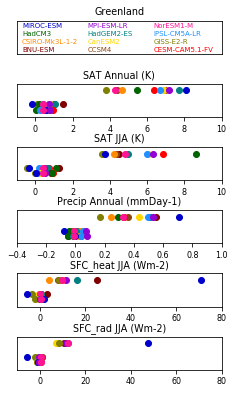

In [112]:
"""
Test CO2 and G1x anomalies
"""

y_CO2 = 0.8
y_G1 = 0.38
y_G1x = 0.22

def plot_anom_set(mask, seas, var, test=True):
    
    CO2_anom = get_model_data(mask, seas, var, 'CO2_anom')
    G1_anom = get_model_data(mask, seas, var, 'G1_anom')
    G1x_anom = get_model_data(mask, seas, var, 'G1x_anom')

    plot_models(y_CO2, CO2_anom)
    plot_models(y_G1, G1_anom)
    plot_models(y_G1x, G1x_anom)
                  
    if test:
        print np.nanmax(np.concatenate((CO2_anom,G1_anom,G1x_anom))), np.nanmin(np.concatenate((CO2_anom,G1_anom,G1x_anom)))

"""
Greenland
"""

fig = plt.figure(figsize=cm2inch(8.5,14))

"""
Legend
"""
ax = fig.add_subplot(611)

# array of model names
nx, ny = (3,4)
x = np.linspace(0.03,0.8,nx)
y = np.linspace(0.07,0.8,ny)
xv,yv = np.meshgrid(x,y)
xv, yv = (xv.flatten(), yv.flatten())

# plot model_names
for i in xrange(n_models):
    plt.text(xv[i], yv[i], models[i],color=model_cols[i], fontsize=7)

ax.set_ylim(0,1)
ax.set_xlim(0,1.2)
ax.set_title('Greenland')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
# ax.get_xaxis().set_ticklabels([])
# ax.get_yaxis().set_ticklabels([])

"""
SAT ann plot
"""
ax = fig.add_subplot(612)

plot_anom_set('greenland', 'ann', 'tas')

ax.set_ylim(0,1)
ax.set_xlim(-1,10)
ax.set_title('SAT Annual (K)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

"""
SAT JJA plot
"""
ax = fig.add_subplot(613)

plot_anom_set('greenland', 'jja', 'tas')

ax.set_ylim(0,1)
ax.set_xlim(-1,10)
ax.set_title('SAT JJA (K)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

"""
Precip Ann plot
"""
ax = fig.add_subplot(614)

plot_anom_set('greenland', 'ann', 'pr')

ax.set_ylim(0,1)
ax.set_xlim(-0.4,1)
ax.set_title('Precip Annual (mmDay-1)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

"""
sfc_heat JJA plot
"""
ax = fig.add_subplot(615)

plot_anom_set('greenland', 'jja', 'sfc_heat')

ax.set_ylim(0,1)
ax.set_xlim(-10,80)
ax.set_title('SFC_heat JJA (Wm-2)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

"""
sfc_rad JJA plot
"""
ax = fig.add_subplot(616)

plot_anom_set('greenland', 'jja', 'sfc_rad')

ax.set_ylim(0,1)
ax.set_xlim(-10,80)
ax.set_title('SFC_rad JJA (Wm-2)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

"""
Finish up figure
"""

plt.subplots_adjust(top=0.98, bottom=0.1, left=0.10, right=0.95, hspace=0.9,
                    wspace=0.35)

plt.savefig(out_dir+'greenland_anoms.png', format='png', dpi=480)
plt.savefig(out_dir+'greenland_anoms.eps', format='eps', dpi=480)

plt.show()

10.828196719945314 -0.38511831275913977
17.254999807235105 -0.5783077203457907
0.39587283346399005 -0.03799862521813857
4.733212419243795 -2.363102021421838
7.874318548731257 -1.6140463308316977


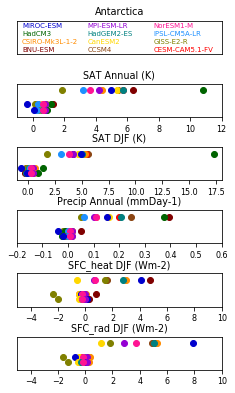

In [113]:
"""
Antarctica
"""

fig = plt.figure(figsize=cm2inch(8.5,14))

"""
Legend
"""
ax = fig.add_subplot(611)

# array of model names
nx, ny = (3,4)
x = np.linspace(0.03,0.8,nx)
y = np.linspace(0.07,0.8,ny)
xv,yv = np.meshgrid(x,y)
xv, yv = (xv.flatten(), yv.flatten())

# plot model_names
for i in xrange(n_models):
    plt.text(xv[i], yv[i], models[i],color=model_cols[i], fontsize=7)

ax.set_ylim(0,1)
ax.set_xlim(0,1.2)
ax.set_title('Antarctica')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
# ax.get_xaxis().set_ticklabels([])
# ax.get_yaxis().set_ticklabels([])

"""
SAT ann plot
"""
ax = fig.add_subplot(612)

plot_anom_set('antarctica', 'ann', 'tas')

ax.set_ylim(0,1)
ax.set_xlim(-1,12)
ax.set_title('SAT Annual (K)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

"""
SAT DJF plot
"""
ax = fig.add_subplot(613)

plot_anom_set('antarctica', 'djf', 'tas')

ax.set_ylim(0,1)
ax.set_xlim(-1,18)
ax.set_title('SAT DJF (K)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

"""
Precip Ann plot
"""
ax = fig.add_subplot(614)

plot_anom_set('antarctica', 'ann', 'pr')

ax.set_ylim(0,1)
ax.set_xlim(-0.2,0.6)
ax.set_title('Precip Annual (mmDay-1)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

"""
sfc_heat DJF plot
"""
ax = fig.add_subplot(615)

plot_anom_set('antarctica', 'djf', 'sfc_heat')

ax.set_ylim(0,1)
ax.set_xlim(-5,10)
ax.set_title('SFC_heat DJF (Wm-2)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

"""
sfc_rad DJF plot
"""
ax = fig.add_subplot(616)

plot_anom_set('antarctica', 'djf', 'sfc_rad')

ax.set_ylim(0,1)
ax.set_xlim(-5,10)
ax.set_title('SFC_rad DJF (Wm-2)')
plt.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)

"""
Finish up figure
"""

plt.subplots_adjust(top=0.98, bottom=0.1, left=0.10, right=0.95, hspace=0.9,
                    wspace=0.35)

plt.savefig(out_dir+'antarctica_anoms.png', format='png', dpi=480)
plt.savefig(out_dir+'antarctica_anoms.eps', format='eps', dpi=480)

plt.show()

# Mean results

In [ ]:
# get dataframes
globe = df_dict['global','ann']
land_noice = df_dict['land_noice','ann']
greenland = df_dict['greenland','ann']
antarctica = df_dict['antarctica','ann']
gr_summer = df_dict['greenland','jja']
ant_summer = df_dict['antarctica','djf']

## global energetics
Global surface heat budget is not balanced in piControl, all models are taking up heat into the ocean and land. GISS has a very large energy imbalance!

In [ ]:
globe[['sfc_heat_pic','sfc_heat_CO2_anom', 'sfc_heat_G1_anom']]

In [ ]:
land_noice[['sfc_heat_pic','sfc_heat_CO2_anom', 'sfc_heat_G1_anom']]

In [ ]:
globe[['tas_pic','tas_CO2_anom', 'tas_G1_anom']]

### modest evidence of over-effectiveness on total heat flux
The energy budget over Greenland and Antartcica is different between models, some show modest heat fluxes in and others show modest heat fluxes out. Median control heat fluxes are GR: -0.4 Wm-2 and ANT: -0.7, for CO2 there is a considerable warming of Greenland GR: 3.9 Wm-2, and little effect on antarctica ANT: 0.4 Wm-2, for G1 there is a modest reduction compared to control GR: -0.03, ANT: -0.05

In [ ]:
greenland[['sfc_heat_pic','sfc_heat_CO2_anom', 'sfc_heat_G1_anom']]

In [ ]:
antarctica[['sfc_heat_pic','sfc_heat_CO2_anom', 'sfc_heat_G1_anom']]

### on radiative side, there is a considerable heating compared to control
Both greenland and antarctica are radiatively cooling to the tune of 15-20 WM-2 in control (heated by specific and latent heating to "balance"), at 2xCO2 Greenland heats by ~6 Wm-2 and Ant by ~2.5 Wm-2. this is reduced to ~0.7Wm-2 and ~0.5 Wm-2 in G1.

In [ ]:
greenland[['sfc_rad_pic','sfc_rad_CO2_anom', 'sfc_rad_G1_anom']]

In [ ]:
antarctica[['sfc_rad_pic','sfc_rad_CO2_anom', 'sfc_rad_G1_anom']]

### heat fluxes
in picontrol heat fluxes warm Greenland and Antarctica to tune of ~15 Wm-2. There is a reduction in heat fluxes into greenland and antarctica in 2xCO2, GR:-1.5, ANT:-2.2, partially offsetting increased radiative heating in Greenland and mostly offsetting it in Antarctica. in G1 the reduction in heat fluxes is moderated, GR:-0.8, ANT:-0.7.

In [ ]:
greenland[['sfc_nonrad_pic','sfc_nonrad_CO2_anom', 'sfc_nonrad_G1_anom']]

In [ ]:
antarctica[['sfc_nonrad_pic','sfc_nonrad_CO2_anom', 'sfc_nonrad_G1_anom']]

## Accumulalation
For most models ~90% of precip is as snow on greenland and ~100% for Antarctica in control. P-E is close to P in all models, due to low total evap rates.

In [ ]:
greenland[['pr_pic','prsn_pic','p-e_pic']]

In [ ]:
antarctica[['pr_pic','prsn_pic','p-e_pic']]

### precip change
GR and ANT both see a significant increase in precip at high CO2. This is basically completely offset in G1.

In [ ]:
greenland[['pr_pic','pr_CO2_anom','pr_G1_anom']]

In [ ]:
antarctica[['pr_pic','pr_CO2_anom','pr_G1_anom']]

### lying snow

In [ ]:
greenland[['snw_pic','snw_CO2_anom','snw_G1_anom']]

In [ ]:
antarctica[['snw_pic','snw_CO2_anom','snw_G1_anom']]

## Summer changes

### SAT
Most of summer temp increase is offset by G1, though somewhat more effectively in Ant.

In [ ]:
gr_summer[['tas_pic','tas_CO2_anom','tas_G1_anom']]

In [ ]:
ant_summer[['tas_pic','tas_CO2_anom','tas_G1_anom']]

### snow melt
Increases in snow melt are generally offset but large differences between models and few models with data makes it tricky to be certain.

In [ ]:
gr_summer[['snm_pic','snm_CO2_anom','snm_G1_anom']]

In [ ]:
ant_summer[['snm_pic','snm_CO2_anom','snm_G1_anom']]

### radiative changes in Greenland summer
The large increase in summer sfc heat flux into the ice is generally offset in G1 +0.08Wm-2, there is a somewhat greater reduction in summer surface radiation which ends somewhat below control -0.4 Wm-2, offset by greater LH and SH heat fluxes. There is a significant reduction in net SW at surface -2.5 Wm-2 that is offset by greater LW at surface +2.0 Wm-2

In [ ]:
gr_summer[['sfc_heat_pic','sfc_heat_CO2_anom','sfc_heat_G1_anom']]

In [ ]:
gr_summer[['sfc_rad_pic','sfc_rad_CO2_anom','sfc_rad_G1_anom']]

In [ ]:
gr_summer[['sfc_sw_pic','sfc_sw_CO2_anom','sfc_sw_G1_anom']]

In [ ]:
gr_summer[['sfc_lw_pic','sfc_lw_CO2_anom','sfc_lw_G1_anom']]

### radiative changes in Antarctic summer
slight net reduction in ANT sfc heat -0.2 Wm-2, explained by rad -0.15 Wm-2, -3.0 Wm-2 sfc SW mostly offset by LW increase +2.85 Wm-2

In [ ]:
ant_summer[['sfc_heat_pic','sfc_heat_CO2_anom','sfc_heat_G1_anom']]

In [ ]:
ant_summer[['sfc_rad_pic','sfc_rad_CO2_anom','sfc_rad_G1_anom']]

In [ ]:
ant_summer[['sfc_sw_pic','sfc_sw_CO2_anom','sfc_sw_G1_anom']]

In [ ]:
ant_summer[['sfc_lw_pic','sfc_lw_CO2_anom','sfc_lw_G1_anom']]

In [ ]:
print globe.columns.values

### Variables for reference

In [ ]:
# Climate stuff
add_var('tas_Amon',k2c,0.0, "")         # 2m temp
add_var('pe_Amon', 0.0, s2d, "")            # Precip
add_var('prsn_Amon', 0.0, s2d, "")          # snowfall
add_var('evspsbl_Amon', 0.0, s2d, "")       # total evap
add_var('sbl_Amon', 0.0, s2d, "")           # sublimation
add_var('ts_Amon', k2c, 0.0, "")        # surface temp
add_var('hurs_Amon', 0.0, 0.0, "")          # relative humidity
# Energy flux at surface
add_var('rlus_Amon',0.0,0.0,"")             # LW up 
add_var('rlds_Amon',0.0,0.0,"")             # LW down
add_var('rsus_Amon',0.0,0.0,"")             # SW up
add_var('rsds_Amon',0.0,0.0,"")             # SW down
add_var('hfss_Amon',0.0,0.0,"")             # sensible heat up
add_var('hfls_Amon',0.0,0.0,"")             # latent heat up
means_dict['sfc_heat_Amon', model, exp, seas] = sfc_heat
means_dict['sfc_rad_Amon', model, exp, seas] = sfc_rad
# Snow Stuff
add_var('lwsnl_LImon',0.0,0.0,"")           # liquid water snow
add_var('snd_LImon',0.0,0.0,"")             # fresh snow thickness
add_var('snm_LImon',0.0,s2d,"")             # snow melt
add_var('hfdsn_LImon',0.0,0.0,"")           # heat flux into snow
add_var('tsn_LImon',k2c,0.0,"")         # snow temperature
add_var('snw_LImon',0.0,0.0,"")             # snow mass